In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
from keras.constraints import Constraint
import pickle

In [2]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [3]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [4]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [5]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
          C_A_list.append(C_A - C_As)  # in deviation form
          T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [6]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [7]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [9]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

CA0_input_neg = -np.array(CA0_input)
CA0_input_neg = CA0_input_neg.reshape(-1,1,1)

Q_input_neg = -np.array(Q_input)
Q_input_neg = Q_input_neg.reshape(-1,1,1)

CA_input_neg = -np.array(CA_input)
CA_input_neg = CA_input_neg.reshape(-1,1,1)

T_input_neg = -np.array(T_input)
T_input_neg = T_input_neg.reshape(-1,1,1)

RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 4)


In [10]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]


In [11]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [12]:
# checking output
print(RNN_output[0, :5])

[[-74.82498608   1.43869052]
 [-75.94937347   1.43097798]
 [-77.07255531   1.4233169 ]
 [-78.19443649   1.41570516]
 [-79.31492759   1.4081408 ]]


In [13]:
class MyLRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, eps=0.01, gamma=0.01, beta=0.8, alpha=1, **kwargs):
        self.units = units
        self.state_size = units
        self.I = tf.eye(units)
        self.eps = eps
        self.gamma = gamma
        self.beta = beta
        self.alpha = alpha
        super(MyLRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.C = self.add_weight(shape=(self.units, self.units),
                                      initializer='random_normal',
                                      name='C',
                                      trainable=True)
        self.B = self.add_weight(shape=(self.units, self.units),
                                                initializer='random_normal',
                                                name='B',
                                                trainable=True)
        self.U = self.add_weight(shape=(input_shape[-1], self.units),
                                                initializer='random_normal',
                                                name='U',
                                                trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    name='b',
                                    trainable=True)
        self.built = True

    def call(self, inputs, states):
        prev_h = states[0]

        A = self.beta * (self.B - tf.transpose(self.B)) + (1 - self.beta) * (self.B + tf.transpose(self.B)) - self.gamma * self.I
        W = self.beta * (self.C - tf.transpose(self.C)) + (1 - self.beta) * (self.C + tf.transpose(self.C)) - self.gamma * self.I

        h = prev_h + self.eps * self.alpha * K.dot(prev_h, A) + self.eps * tf.nn.tanh(K.dot(prev_h, W) + K.dot(inputs, self.U) + self.b)
        return h, [h]

    def get_config(self):
        config = super(MyLRNNCell, self).get_config()
        config.update({"units": self.units, "eps":self.eps, "gamma":self.gamma, "beta":self.beta, "alpha":self.alpha})
        return config

In [27]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*10
test_loss = [0]*10
noise = 0
for i in range(10):
  num_dims = 4

  # split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

  # # define scalers for both X and y base on training data only
  scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, num_dims))
  scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))

  X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
  y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
  y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

  y_train = y_train + np.random.normal(0, noise, y_train.shape)

  model = Sequential()
  model.add(RNN(MyLRNNCell(units=512),return_sequences=True))
  model.add(RNN(MyLRNNCell(units=512),return_sequences=True))
  model.add(Dense(2, activation='linear'))

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
  history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_split=0.25, verbose=2)
  training_loss[i] = history.history['val_loss'][-1]
  print(noise)
  print(training_loss)

  loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
  test_loss[i] = loss[0]
  print(test_loss)

  name = 'lrnn_512_'
  name = name + str(noise) + '.h5'
  model.save(name)

  noise = noise + 0.1

model.summary()

Epoch 1/200
26/26 - 35s - loss: 0.9527 - mean_squared_error: 0.9527 - val_loss: 0.8249 - val_mean_squared_error: 0.8249 - 35s/epoch - 1s/step
Epoch 2/200
26/26 - 20s - loss: 0.6083 - mean_squared_error: 0.6083 - val_loss: 0.4635 - val_mean_squared_error: 0.4635 - 20s/epoch - 765ms/step
Epoch 3/200
26/26 - 20s - loss: 0.4260 - mean_squared_error: 0.4260 - val_loss: 0.3710 - val_mean_squared_error: 0.3710 - 20s/epoch - 764ms/step
Epoch 4/200
26/26 - 20s - loss: 0.3212 - mean_squared_error: 0.3212 - val_loss: 0.2742 - val_mean_squared_error: 0.2742 - 20s/epoch - 764ms/step
Epoch 5/200
26/26 - 20s - loss: 0.2664 - mean_squared_error: 0.2664 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - 20s/epoch - 760ms/step
Epoch 6/200
26/26 - 20s - loss: 0.2472 - mean_squared_error: 0.2472 - val_loss: 0.2348 - val_mean_squared_error: 0.2348 - 20s/epoch - 757ms/step
Epoch 7/200
26/26 - 20s - loss: 0.2264 - mean_squared_error: 0.2264 - val_loss: 0.2123 - val_mean_squared_error: 0.2123 - 20s/epoch -

Epoch 58/200
26/26 - 19s - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - 19s/epoch - 727ms/step
Epoch 59/200
26/26 - 19s - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - 19s/epoch - 739ms/step
Epoch 60/200
26/26 - 20s - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - 20s/epoch - 774ms/step
Epoch 61/200
26/26 - 20s - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - 20s/epoch - 784ms/step
Epoch 62/200
26/26 - 20s - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - 20s/epoch - 773ms/step
Epoch 63/200
26/26 - 20s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - 20s/epoch - 777ms/step
Epoch 64/200
26/26 - 20s - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - 2

26/26 - 20s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - 20s/epoch - 784ms/step
Epoch 115/200
26/26 - 19s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - 19s/epoch - 730ms/step
Epoch 116/200
26/26 - 19s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - 19s/epoch - 735ms/step
Epoch 117/200
26/26 - 20s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - 20s/epoch - 773ms/step
Epoch 118/200
26/26 - 20s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - 20s/epoch - 785ms/step
Epoch 119/200
26/26 - 20s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - 20s/epoch - 778ms/step
Epoch 120/200
26/26 - 20s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - 20s/epoc

Epoch 171/200
26/26 - 31s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - 31s/epoch - 1s/step
Epoch 172/200
26/26 - 31s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - 31s/epoch - 1s/step
Epoch 173/200
26/26 - 31s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - 31s/epoch - 1s/step
Epoch 174/200
26/26 - 30s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - 30s/epoch - 1s/step
Epoch 175/200
26/26 - 30s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - 30s/epoch - 1s/step
Epoch 176/200
26/26 - 28s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - 28s/epoch - 1s/step
Epoch 177/200
26/26 - 26s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - 26s/epoch - 

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 446s - loss: 0.9591 - mean_squared_error: 0.9591 - val_loss: 0.8264 - val_mean_squared_error: 0.8264 - 446s/epoch - 17s/step
Epoch 2/200
26/26 - 24s - loss: 0.6100 - mean_squared_error: 0.6100 - val_loss: 0.4729 - val_mean_squared_error: 0.4729 - 24s/epoch - 927ms/step
Epoch 3/200
26/26 - 24s - loss: 0.4327 - mean_squared_error: 0.4327 - val_loss: 0.3767 - val_mean_squared_error: 0.3767 - 24s/epoch - 925ms/step
Epoch 4/200
26/26 - 24s - loss: 0.3274 - mean_squared_error: 0.3274 - val_loss: 0.2833 - val_mean_squared_error: 0.2833 - 24s/epoch - 929ms/step
Epoch 5/200
26/26 - 24s - loss: 0.2756 - mean_squared_error: 0.2756 - val_loss: 0.2640 - val_mean_squared_error: 0.2640 - 24s/epoch - 929ms/step
Epoch 6/200
26/26 - 24s - loss: 0.2562 - mean_squared_error: 0.2562 - val_loss: 0.2442 - val_mean_squared_error: 0.2442 - 24s/epoch - 906ms/step
Epoch 7/200
26/26 - 23s - loss: 0.2351 - mean_squared_error: 0.2351 - val_loss: 0.2217 - val_mean_squared_error: 0.2217 - 23s/epoc

Epoch 58/200
26/26 - 30s - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - 30s/epoch - 1s/step
Epoch 59/200
26/26 - 30s - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - 30s/epoch - 1s/step
Epoch 60/200
26/26 - 30s - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - 30s/epoch - 1s/step
Epoch 61/200
26/26 - 30s - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - 30s/epoch - 1s/step
Epoch 62/200
26/26 - 30s - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - 30s/epoch - 1s/step
Epoch 63/200
26/26 - 30s - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - 30s/epoch - 1s/step
Epoch 64/200
26/26 - 30s - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - 30s/epoch - 1s/step

Epoch 115/200
26/26 - 25s - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 25s/epoch - 960ms/step
Epoch 116/200
26/26 - 25s - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 25s/epoch - 980ms/step
Epoch 117/200
26/26 - 26s - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 26s/epoch - 986ms/step
Epoch 118/200
26/26 - 25s - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - 25s/epoch - 954ms/step
Epoch 119/200
26/26 - 24s - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - 24s/epoch - 939ms/step
Epoch 120/200
26/26 - 26s - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - 26s/epoch - 1s/step
Epoch 121/200
26/26 - 26s - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0154 - val_mean_squared_error: 0.0154

Epoch 172/200
26/26 - 17s - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - 17s/epoch - 655ms/step
Epoch 173/200
26/26 - 19s - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - 19s/epoch - 716ms/step
Epoch 174/200
26/26 - 22s - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - 22s/epoch - 857ms/step
Epoch 175/200
26/26 - 25s - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - 25s/epoch - 958ms/step
Epoch 176/200
26/26 - 27s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - 27s/epoch - 1s/step
Epoch 177/200
26/26 - 27s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - 27s/epoch - 1s/step
Epoch 178/200
26/26 - 26s - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - 

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 216s - loss: 0.9887 - mean_squared_error: 0.9887 - val_loss: 0.8581 - val_mean_squared_error: 0.8581 - 216s/epoch - 8s/step
Epoch 2/200
26/26 - 21s - loss: 0.6406 - mean_squared_error: 0.6406 - val_loss: 0.5039 - val_mean_squared_error: 0.5039 - 21s/epoch - 813ms/step
Epoch 3/200
26/26 - 21s - loss: 0.4625 - mean_squared_error: 0.4625 - val_loss: 0.4073 - val_mean_squared_error: 0.4073 - 21s/epoch - 808ms/step
Epoch 4/200
26/26 - 21s - loss: 0.3566 - mean_squared_error: 0.3566 - val_loss: 0.3147 - val_mean_squared_error: 0.3147 - 21s/epoch - 805ms/step
Epoch 5/200
26/26 - 21s - loss: 0.3049 - mean_squared_error: 0.3049 - val_loss: 0.2956 - val_mean_squared_error: 0.2956 - 21s/epoch - 806ms/step
Epoch 6/200
26/26 - 21s - loss: 0.2857 - mean_squared_error: 0.2857 - val_loss: 0.2756 - val_mean_squared_error: 0.2756 - 21s/epoch - 798ms/step
Epoch 7/200
26/26 - 21s - loss: 0.2647 - mean_squared_error: 0.2647 - val_loss: 0.2529 - val_mean_squared_error: 0.2529 - 21s/epoch

Epoch 58/200
26/26 - 20s - loss: 0.0574 - mean_squared_error: 0.0574 - val_loss: 0.0578 - val_mean_squared_error: 0.0578 - 20s/epoch - 784ms/step
Epoch 59/200
26/26 - 19s - loss: 0.0569 - mean_squared_error: 0.0569 - val_loss: 0.0575 - val_mean_squared_error: 0.0575 - 19s/epoch - 738ms/step
Epoch 60/200
26/26 - 19s - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 0.0570 - val_mean_squared_error: 0.0570 - 19s/epoch - 732ms/step
Epoch 61/200
26/26 - 19s - loss: 0.0562 - mean_squared_error: 0.0562 - val_loss: 0.0566 - val_mean_squared_error: 0.0566 - 19s/epoch - 736ms/step
Epoch 62/200
26/26 - 19s - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.0565 - val_mean_squared_error: 0.0565 - 19s/epoch - 743ms/step
Epoch 63/200
26/26 - 19s - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 0.0560 - val_mean_squared_error: 0.0560 - 19s/epoch - 737ms/step
Epoch 64/200
26/26 - 19s - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0556 - val_mean_squared_error: 0.0556 - 1

26/26 - 11s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - 11s/epoch - 436ms/step
Epoch 115/200
26/26 - 11s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0466 - val_mean_squared_error: 0.0466 - 11s/epoch - 434ms/step
Epoch 116/200
26/26 - 11s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - 11s/epoch - 435ms/step
Epoch 117/200
26/26 - 11s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - 11s/epoch - 441ms/step
Epoch 118/200
26/26 - 12s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - 12s/epoch - 447ms/step
Epoch 119/200
26/26 - 12s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0461 - val_mean_squared_error: 0.0461 - 12s/epoch - 475ms/step
Epoch 120/200
26/26 - 13s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0461 - val_mean_squared_error: 0.0461 - 13s/epoc

Epoch 170/200
26/26 - 14s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - 14s/epoch - 552ms/step
Epoch 171/200
26/26 - 14s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - 14s/epoch - 551ms/step
Epoch 172/200
26/26 - 15s - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - 15s/epoch - 562ms/step
Epoch 173/200
26/26 - 14s - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - 14s/epoch - 554ms/step
Epoch 174/200
26/26 - 15s - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - 15s/epoch - 585ms/step
Epoch 175/200
26/26 - 15s - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - 15s/epoch - 576ms/step
Epoch 176/200
26/26 - 16s - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0437 - val_mean_squared_error: 0.0

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 202s - loss: 1.0376 - mean_squared_error: 1.0376 - val_loss: 0.9074 - val_mean_squared_error: 0.9074 - 202s/epoch - 8s/step
Epoch 2/200
26/26 - 20s - loss: 0.6876 - mean_squared_error: 0.6876 - val_loss: 0.5554 - val_mean_squared_error: 0.5554 - 20s/epoch - 778ms/step
Epoch 3/200
26/26 - 20s - loss: 0.5119 - mean_squared_error: 0.5119 - val_loss: 0.4594 - val_mean_squared_error: 0.4594 - 20s/epoch - 779ms/step
Epoch 4/200
26/26 - 20s - loss: 0.4077 - mean_squared_error: 0.4077 - val_loss: 0.3640 - val_mean_squared_error: 0.3640 - 20s/epoch - 775ms/step
Epoch 5/200
26/26 - 20s - loss: 0.3549 - mean_squared_error: 0.3549 - val_loss: 0.3443 - val_mean_squared_error: 0.3443 - 20s/epoch - 779ms/step
Epoch 6/200
26/26 - 21s - loss: 0.3364 - mean_squared_error: 0.3364 - val_loss: 0.3255 - val_mean_squared_error: 0.3255 - 21s/epoch - 789ms/step
Epoch 7/200
26/26 - 20s - loss: 0.3164 - mean_squared_error: 0.3164 - val_loss: 0.3041 - val_mean_squared_error: 0.3041 - 20s/epoch

Epoch 58/200
26/26 - 16s - loss: 0.1087 - mean_squared_error: 0.1087 - val_loss: 0.1087 - val_mean_squared_error: 0.1087 - 16s/epoch - 631ms/step
Epoch 59/200
26/26 - 16s - loss: 0.1083 - mean_squared_error: 0.1083 - val_loss: 0.1082 - val_mean_squared_error: 0.1082 - 16s/epoch - 629ms/step
Epoch 60/200
26/26 - 16s - loss: 0.1079 - mean_squared_error: 0.1079 - val_loss: 0.1079 - val_mean_squared_error: 0.1079 - 16s/epoch - 624ms/step
Epoch 61/200
26/26 - 17s - loss: 0.1076 - mean_squared_error: 0.1076 - val_loss: 0.1075 - val_mean_squared_error: 0.1075 - 17s/epoch - 637ms/step
Epoch 62/200
26/26 - 16s - loss: 0.1072 - mean_squared_error: 0.1072 - val_loss: 0.1074 - val_mean_squared_error: 0.1074 - 16s/epoch - 630ms/step
Epoch 63/200
26/26 - 16s - loss: 0.1069 - mean_squared_error: 0.1069 - val_loss: 0.1068 - val_mean_squared_error: 0.1068 - 16s/epoch - 633ms/step
Epoch 64/200
26/26 - 15s - loss: 0.1064 - mean_squared_error: 0.1064 - val_loss: 0.1070 - val_mean_squared_error: 0.1070 - 1

26/26 - 16s - loss: 0.0975 - mean_squared_error: 0.0975 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 16s/epoch - 598ms/step
Epoch 115/200
26/26 - 15s - loss: 0.0972 - mean_squared_error: 0.0972 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 15s/epoch - 593ms/step
Epoch 116/200
26/26 - 15s - loss: 0.0971 - mean_squared_error: 0.0971 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 15s/epoch - 585ms/step
Epoch 117/200
26/26 - 15s - loss: 0.0970 - mean_squared_error: 0.0970 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 15s/epoch - 585ms/step
Epoch 118/200
26/26 - 15s - loss: 0.0969 - mean_squared_error: 0.0969 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 15s/epoch - 593ms/step
Epoch 119/200
26/26 - 15s - loss: 0.0968 - mean_squared_error: 0.0968 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 15s/epoch - 581ms/step
Epoch 120/200
26/26 - 15s - loss: 0.0968 - mean_squared_error: 0.0968 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - 15s/epoc

Epoch 170/200
26/26 - 15s - loss: 0.0944 - mean_squared_error: 0.0944 - val_loss: 0.0950 - val_mean_squared_error: 0.0950 - 15s/epoch - 582ms/step
Epoch 171/200
26/26 - 15s - loss: 0.0944 - mean_squared_error: 0.0944 - val_loss: 0.0947 - val_mean_squared_error: 0.0947 - 15s/epoch - 584ms/step
Epoch 172/200
26/26 - 15s - loss: 0.0944 - mean_squared_error: 0.0944 - val_loss: 0.0945 - val_mean_squared_error: 0.0945 - 15s/epoch - 578ms/step
Epoch 173/200
26/26 - 15s - loss: 0.0943 - mean_squared_error: 0.0943 - val_loss: 0.0943 - val_mean_squared_error: 0.0943 - 15s/epoch - 584ms/step
Epoch 174/200
26/26 - 14s - loss: 0.0942 - mean_squared_error: 0.0942 - val_loss: 0.0948 - val_mean_squared_error: 0.0948 - 14s/epoch - 541ms/step
Epoch 175/200
26/26 - 13s - loss: 0.0943 - mean_squared_error: 0.0943 - val_loss: 0.0943 - val_mean_squared_error: 0.0943 - 13s/epoch - 498ms/step
Epoch 176/200
26/26 - 14s - loss: 0.0942 - mean_squared_error: 0.0942 - val_loss: 0.0943 - val_mean_squared_error: 0.0

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 29s - loss: 1.1072 - mean_squared_error: 1.1072 - val_loss: 0.9742 - val_mean_squared_error: 0.9742 - 29s/epoch - 1s/step
Epoch 2/200
26/26 - 14s - loss: 0.7593 - mean_squared_error: 0.7593 - val_loss: 0.6203 - val_mean_squared_error: 0.6203 - 14s/epoch - 544ms/step
Epoch 3/200
26/26 - 14s - loss: 0.5812 - mean_squared_error: 0.5812 - val_loss: 0.5235 - val_mean_squared_error: 0.5235 - 14s/epoch - 550ms/step
Epoch 4/200
26/26 - 14s - loss: 0.4752 - mean_squared_error: 0.4752 - val_loss: 0.4314 - val_mean_squared_error: 0.4314 - 14s/epoch - 548ms/step
Epoch 5/200
26/26 - 14s - loss: 0.4254 - mean_squared_error: 0.4254 - val_loss: 0.4134 - val_mean_squared_error: 0.4134 - 14s/epoch - 547ms/step
Epoch 6/200
26/26 - 14s - loss: 0.4072 - mean_squared_error: 0.4072 - val_loss: 0.3951 - val_mean_squared_error: 0.3951 - 14s/epoch - 542ms/step
Epoch 7/200
26/26 - 18s - loss: 0.3878 - mean_squared_error: 0.3878 - val_loss: 0.3745 - val_mean_squared_error: 0.3745 - 18s/epoch -

Epoch 58/200
26/26 - 19s - loss: 0.1793 - mean_squared_error: 0.1793 - val_loss: 0.1810 - val_mean_squared_error: 0.1810 - 19s/epoch - 712ms/step
Epoch 59/200
26/26 - 18s - loss: 0.1788 - mean_squared_error: 0.1788 - val_loss: 0.1805 - val_mean_squared_error: 0.1805 - 18s/epoch - 710ms/step
Epoch 60/200
26/26 - 18s - loss: 0.1784 - mean_squared_error: 0.1784 - val_loss: 0.1801 - val_mean_squared_error: 0.1801 - 18s/epoch - 711ms/step
Epoch 61/200
26/26 - 19s - loss: 0.1781 - mean_squared_error: 0.1781 - val_loss: 0.1803 - val_mean_squared_error: 0.1803 - 19s/epoch - 713ms/step
Epoch 62/200
26/26 - 19s - loss: 0.1776 - mean_squared_error: 0.1776 - val_loss: 0.1793 - val_mean_squared_error: 0.1793 - 19s/epoch - 720ms/step
Epoch 63/200
26/26 - 19s - loss: 0.1776 - mean_squared_error: 0.1776 - val_loss: 0.1793 - val_mean_squared_error: 0.1793 - 19s/epoch - 717ms/step
Epoch 64/200
26/26 - 19s - loss: 0.1769 - mean_squared_error: 0.1769 - val_loss: 0.1785 - val_mean_squared_error: 0.1785 - 1

26/26 - 19s - loss: 0.1673 - mean_squared_error: 0.1673 - val_loss: 0.1688 - val_mean_squared_error: 0.1688 - 19s/epoch - 714ms/step
Epoch 115/200
26/26 - 19s - loss: 0.1672 - mean_squared_error: 0.1672 - val_loss: 0.1687 - val_mean_squared_error: 0.1687 - 19s/epoch - 713ms/step
Epoch 116/200
26/26 - 19s - loss: 0.1670 - mean_squared_error: 0.1670 - val_loss: 0.1686 - val_mean_squared_error: 0.1686 - 19s/epoch - 717ms/step
Epoch 117/200
26/26 - 19s - loss: 0.1668 - mean_squared_error: 0.1668 - val_loss: 0.1683 - val_mean_squared_error: 0.1683 - 19s/epoch - 714ms/step
Epoch 118/200
26/26 - 19s - loss: 0.1667 - mean_squared_error: 0.1667 - val_loss: 0.1682 - val_mean_squared_error: 0.1682 - 19s/epoch - 715ms/step
Epoch 119/200
26/26 - 19s - loss: 0.1665 - mean_squared_error: 0.1665 - val_loss: 0.1684 - val_mean_squared_error: 0.1684 - 19s/epoch - 718ms/step
Epoch 120/200
26/26 - 19s - loss: 0.1666 - mean_squared_error: 0.1666 - val_loss: 0.1681 - val_mean_squared_error: 0.1681 - 19s/epoc

Epoch 170/200
26/26 - 20s - loss: 0.1640 - mean_squared_error: 0.1640 - val_loss: 0.1656 - val_mean_squared_error: 0.1656 - 20s/epoch - 781ms/step
Epoch 171/200
26/26 - 20s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1659 - val_mean_squared_error: 0.1659 - 20s/epoch - 786ms/step
Epoch 172/200
26/26 - 20s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1658 - val_mean_squared_error: 0.1658 - 20s/epoch - 778ms/step
Epoch 173/200
26/26 - 20s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1659 - val_mean_squared_error: 0.1659 - 20s/epoch - 786ms/step
Epoch 174/200
26/26 - 20s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1656 - val_mean_squared_error: 0.1656 - 20s/epoch - 781ms/step
Epoch 175/200
26/26 - 20s - loss: 0.1637 - mean_squared_error: 0.1637 - val_loss: 0.1654 - val_mean_squared_error: 0.1654 - 20s/epoch - 782ms/step
Epoch 176/200
26/26 - 20s - loss: 0.1637 - mean_squared_error: 0.1637 - val_loss: 0.1655 - val_mean_squared_error: 0.1

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 31s - loss: 1.1985 - mean_squared_error: 1.1985 - val_loss: 1.0587 - val_mean_squared_error: 1.0587 - 31s/epoch - 1s/step
Epoch 2/200
26/26 - 21s - loss: 0.8496 - mean_squared_error: 0.8496 - val_loss: 0.7081 - val_mean_squared_error: 0.7081 - 21s/epoch - 789ms/step
Epoch 3/200
26/26 - 21s - loss: 0.6746 - mean_squared_error: 0.6746 - val_loss: 0.6117 - val_mean_squared_error: 0.6117 - 21s/epoch - 790ms/step
Epoch 4/200
26/26 - 20s - loss: 0.5686 - mean_squared_error: 0.5686 - val_loss: 0.5173 - val_mean_squared_error: 0.5173 - 20s/epoch - 786ms/step
Epoch 5/200
26/26 - 20s - loss: 0.5164 - mean_squared_error: 0.5164 - val_loss: 0.4982 - val_mean_squared_error: 0.4982 - 20s/epoch - 785ms/step
Epoch 6/200
26/26 - 20s - loss: 0.4977 - mean_squared_error: 0.4977 - val_loss: 0.4792 - val_mean_squared_error: 0.4792 - 20s/epoch - 786ms/step
Epoch 7/200
26/26 - 20s - loss: 0.4775 - mean_squared_error: 0.4775 - val_loss: 0.4583 - val_mean_squared_error: 0.4583 - 20s/epoch -

Epoch 58/200
26/26 - 20s - loss: 0.2711 - mean_squared_error: 0.2711 - val_loss: 0.2657 - val_mean_squared_error: 0.2657 - 20s/epoch - 770ms/step
Epoch 59/200
26/26 - 19s - loss: 0.2704 - mean_squared_error: 0.2704 - val_loss: 0.2654 - val_mean_squared_error: 0.2654 - 19s/epoch - 716ms/step
Epoch 60/200
26/26 - 18s - loss: 0.2701 - mean_squared_error: 0.2701 - val_loss: 0.2672 - val_mean_squared_error: 0.2672 - 18s/epoch - 698ms/step
Epoch 61/200
26/26 - 18s - loss: 0.2706 - mean_squared_error: 0.2706 - val_loss: 0.2648 - val_mean_squared_error: 0.2648 - 18s/epoch - 699ms/step
Epoch 62/200
26/26 - 18s - loss: 0.2698 - mean_squared_error: 0.2698 - val_loss: 0.2649 - val_mean_squared_error: 0.2649 - 18s/epoch - 695ms/step
Epoch 63/200
26/26 - 18s - loss: 0.2691 - mean_squared_error: 0.2691 - val_loss: 0.2639 - val_mean_squared_error: 0.2639 - 18s/epoch - 696ms/step
Epoch 64/200
26/26 - 18s - loss: 0.2686 - mean_squared_error: 0.2686 - val_loss: 0.2635 - val_mean_squared_error: 0.2635 - 1

26/26 - 19s - loss: 0.2593 - mean_squared_error: 0.2593 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 19s/epoch - 718ms/step
Epoch 115/200
26/26 - 19s - loss: 0.2593 - mean_squared_error: 0.2593 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 19s/epoch - 716ms/step
Epoch 116/200
26/26 - 19s - loss: 0.2593 - mean_squared_error: 0.2593 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 19s/epoch - 719ms/step
Epoch 117/200
26/26 - 19s - loss: 0.2589 - mean_squared_error: 0.2589 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - 19s/epoch - 714ms/step
Epoch 118/200
26/26 - 19s - loss: 0.2589 - mean_squared_error: 0.2589 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 19s/epoch - 719ms/step
Epoch 119/200
26/26 - 19s - loss: 0.2588 - mean_squared_error: 0.2588 - val_loss: 0.2545 - val_mean_squared_error: 0.2545 - 19s/epoch - 721ms/step
Epoch 120/200
26/26 - 19s - loss: 0.2589 - mean_squared_error: 0.2589 - val_loss: 0.2541 - val_mean_squared_error: 0.2541 - 19s/epoc

Epoch 170/200
26/26 - 18s - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.2509 - val_mean_squared_error: 0.2509 - 18s/epoch - 708ms/step
Epoch 171/200
26/26 - 19s - loss: 0.2555 - mean_squared_error: 0.2555 - val_loss: 0.2508 - val_mean_squared_error: 0.2508 - 19s/epoch - 716ms/step
Epoch 172/200
26/26 - 18s - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2507 - val_mean_squared_error: 0.2507 - 18s/epoch - 709ms/step
Epoch 173/200
26/26 - 18s - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2507 - val_mean_squared_error: 0.2507 - 18s/epoch - 711ms/step
Epoch 174/200
26/26 - 19s - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2508 - val_mean_squared_error: 0.2508 - 19s/epoch - 714ms/step
Epoch 175/200
26/26 - 19s - loss: 0.2552 - mean_squared_error: 0.2552 - val_loss: 0.2508 - val_mean_squared_error: 0.2508 - 19s/epoch - 712ms/step
Epoch 176/200
26/26 - 19s - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2507 - val_mean_squared_error: 0.2

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/200
26/26 - 22s - loss: 1.3086 - mean_squared_error: 1.3086 - val_loss: 1.1737 - val_mean_squared_error: 1.1737 - 22s/epoch - 845ms/step
Epoch 2/200
26/26 - 13s - loss: 0.9610 - mean_squared_error: 0.9610 - val_loss: 0.8216 - val_mean_squared_error: 0.8216 - 13s/epoch - 514ms/step
Epoch 3/200
26/26 - 13s - loss: 0.7852 - mean_squared_error: 0.7852 - val_loss: 0.7255 - val_mean_squared_error: 0.7255 - 13s/epoch - 508ms/step
Epoch 4/200
26/26 - 13s - loss: 0.6804 - mean_squared_error: 0.6804 - val_loss: 0.6295 - val_mean_squared_error: 0.6295 - 13s/epoch - 512ms/step
Epoch 5/200
26/26 - 13s - loss: 0.6274 - mean_squared_error: 0.6274 - val_loss: 0.6103 - val_mean_squared_error: 0.6103 - 13s/epoch - 508ms/step
Epoch 6/200
26/26 - 13s - loss: 0.6089 - mean_squared_error: 0.6089 - val_loss: 0.5917 - val_mean_squared_error: 0.5917 - 13s/epoch - 506ms/step
Epoch 7/200
26/26 - 13s - loss: 0.5894 - mean_squared_error: 0.5894 - val_loss: 0.5713 - val_mean_squared_error: 0.5713 - 13s/epoc

Epoch 58/200
26/26 - 13s - loss: 0.3809 - mean_squared_error: 0.3809 - val_loss: 0.3787 - val_mean_squared_error: 0.3787 - 13s/epoch - 514ms/step
Epoch 59/200
26/26 - 13s - loss: 0.3808 - mean_squared_error: 0.3808 - val_loss: 0.3792 - val_mean_squared_error: 0.3792 - 13s/epoch - 516ms/step
Epoch 60/200
26/26 - 13s - loss: 0.3809 - mean_squared_error: 0.3809 - val_loss: 0.3786 - val_mean_squared_error: 0.3786 - 13s/epoch - 511ms/step
Epoch 61/200
26/26 - 13s - loss: 0.3801 - mean_squared_error: 0.3801 - val_loss: 0.3783 - val_mean_squared_error: 0.3783 - 13s/epoch - 511ms/step
Epoch 62/200
26/26 - 13s - loss: 0.3795 - mean_squared_error: 0.3795 - val_loss: 0.3780 - val_mean_squared_error: 0.3780 - 13s/epoch - 511ms/step
Epoch 63/200
26/26 - 13s - loss: 0.3789 - mean_squared_error: 0.3789 - val_loss: 0.3768 - val_mean_squared_error: 0.3768 - 13s/epoch - 519ms/step
Epoch 64/200
26/26 - 13s - loss: 0.3787 - mean_squared_error: 0.3787 - val_loss: 0.3767 - val_mean_squared_error: 0.3767 - 1

Epoch 115/200
26/26 - 8s - loss: 0.3687 - mean_squared_error: 0.3687 - val_loss: 0.3679 - val_mean_squared_error: 0.3679 - 8s/epoch - 306ms/step
Epoch 116/200
26/26 - 8s - loss: 0.3685 - mean_squared_error: 0.3685 - val_loss: 0.3678 - val_mean_squared_error: 0.3678 - 8s/epoch - 306ms/step
Epoch 117/200
26/26 - 8s - loss: 0.3683 - mean_squared_error: 0.3683 - val_loss: 0.3676 - val_mean_squared_error: 0.3676 - 8s/epoch - 305ms/step
Epoch 118/200
26/26 - 8s - loss: 0.3681 - mean_squared_error: 0.3681 - val_loss: 0.3675 - val_mean_squared_error: 0.3675 - 8s/epoch - 305ms/step
Epoch 119/200
26/26 - 8s - loss: 0.3682 - mean_squared_error: 0.3682 - val_loss: 0.3675 - val_mean_squared_error: 0.3675 - 8s/epoch - 306ms/step
Epoch 120/200
26/26 - 8s - loss: 0.3681 - mean_squared_error: 0.3681 - val_loss: 0.3681 - val_mean_squared_error: 0.3681 - 8s/epoch - 305ms/step
Epoch 121/200
26/26 - 8s - loss: 0.3679 - mean_squared_error: 0.3679 - val_loss: 0.3687 - val_mean_squared_error: 0.3687 - 8s/epoc

Epoch 172/200
26/26 - 8s - loss: 0.3650 - mean_squared_error: 0.3650 - val_loss: 0.3649 - val_mean_squared_error: 0.3649 - 8s/epoch - 304ms/step
Epoch 173/200
26/26 - 8s - loss: 0.3649 - mean_squared_error: 0.3649 - val_loss: 0.3650 - val_mean_squared_error: 0.3650 - 8s/epoch - 305ms/step
Epoch 174/200
26/26 - 8s - loss: 0.3650 - mean_squared_error: 0.3650 - val_loss: 0.3656 - val_mean_squared_error: 0.3656 - 8s/epoch - 305ms/step
Epoch 175/200
26/26 - 8s - loss: 0.3649 - mean_squared_error: 0.3649 - val_loss: 0.3648 - val_mean_squared_error: 0.3648 - 8s/epoch - 318ms/step
Epoch 176/200
26/26 - 8s - loss: 0.3648 - mean_squared_error: 0.3648 - val_loss: 0.3656 - val_mean_squared_error: 0.3656 - 8s/epoch - 314ms/step
Epoch 177/200
26/26 - 8s - loss: 0.3651 - mean_squared_error: 0.3651 - val_loss: 0.3657 - val_mean_squared_error: 0.3657 - 8s/epoch - 314ms/step
Epoch 178/200
26/26 - 8s - loss: 0.3649 - mean_squared_error: 0.3649 - val_loss: 0.3648 - val_mean_squared_error: 0.3648 - 8s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 11s - loss: 1.4369 - mean_squared_error: 1.4369 - val_loss: 1.3093 - val_mean_squared_error: 1.3093 - 11s/epoch - 422ms/step
Epoch 2/200
26/26 - 9s - loss: 1.0867 - mean_squared_error: 1.0867 - val_loss: 0.9552 - val_mean_squared_error: 0.9552 - 9s/epoch - 351ms/step
Epoch 3/200
26/26 - 9s - loss: 0.9109 - mean_squared_error: 0.9109 - val_loss: 0.8594 - val_mean_squared_error: 0.8594 - 9s/epoch - 351ms/step
Epoch 4/200
26/26 - 9s - loss: 0.8060 - mean_squared_error: 0.8060 - val_loss: 0.7668 - val_mean_squared_error: 0.7668 - 9s/epoch - 350ms/step
Epoch 5/200
26/26 - 9s - loss: 0.7539 - mean_squared_error: 0.7539 - val_loss: 0.7474 - val_mean_squared_error: 0.7474 - 9s/epoch - 351ms/step
Epoch 6/200
26/26 - 9s - loss: 0.7364 - mean_squared_error: 0.7364 - val_loss: 0.7306 - val_mean_squared_error: 0.7306 - 9s/epoch - 357ms/step
Epoch 7/200
26/26 - 9s - loss: 0.7187 - mean_squared_error: 0.7187 - val_loss: 0.7116 - val_mean_squared_error: 0.7116 - 9s/epoch - 354ms/step
Epoch 8/2

26/26 - 9s - loss: 0.5104 - mean_squared_error: 0.5104 - val_loss: 0.5176 - val_mean_squared_error: 0.5176 - 9s/epoch - 335ms/step
Epoch 59/200
26/26 - 9s - loss: 0.5104 - mean_squared_error: 0.5104 - val_loss: 0.5171 - val_mean_squared_error: 0.5171 - 9s/epoch - 334ms/step
Epoch 60/200
26/26 - 9s - loss: 0.5103 - mean_squared_error: 0.5103 - val_loss: 0.5154 - val_mean_squared_error: 0.5154 - 9s/epoch - 334ms/step
Epoch 61/200
26/26 - 9s - loss: 0.5093 - mean_squared_error: 0.5093 - val_loss: 0.5156 - val_mean_squared_error: 0.5156 - 9s/epoch - 336ms/step
Epoch 62/200
26/26 - 9s - loss: 0.5091 - mean_squared_error: 0.5091 - val_loss: 0.5152 - val_mean_squared_error: 0.5152 - 9s/epoch - 334ms/step
Epoch 63/200
26/26 - 9s - loss: 0.5086 - mean_squared_error: 0.5086 - val_loss: 0.5142 - val_mean_squared_error: 0.5142 - 9s/epoch - 336ms/step
Epoch 64/200
26/26 - 9s - loss: 0.5079 - mean_squared_error: 0.5079 - val_loss: 0.5141 - val_mean_squared_error: 0.5141 - 9s/epoch - 335ms/step
Epoch

Epoch 115/200
26/26 - 9s - loss: 0.4987 - mean_squared_error: 0.4987 - val_loss: 0.5038 - val_mean_squared_error: 0.5038 - 9s/epoch - 335ms/step
Epoch 116/200
26/26 - 9s - loss: 0.4986 - mean_squared_error: 0.4986 - val_loss: 0.5044 - val_mean_squared_error: 0.5044 - 9s/epoch - 336ms/step
Epoch 117/200
26/26 - 9s - loss: 0.4989 - mean_squared_error: 0.4989 - val_loss: 0.5033 - val_mean_squared_error: 0.5033 - 9s/epoch - 334ms/step
Epoch 118/200
26/26 - 9s - loss: 0.4983 - mean_squared_error: 0.4983 - val_loss: 0.5034 - val_mean_squared_error: 0.5034 - 9s/epoch - 334ms/step
Epoch 119/200
26/26 - 9s - loss: 0.4982 - mean_squared_error: 0.4982 - val_loss: 0.5041 - val_mean_squared_error: 0.5041 - 9s/epoch - 336ms/step
Epoch 120/200
26/26 - 9s - loss: 0.4981 - mean_squared_error: 0.4981 - val_loss: 0.5029 - val_mean_squared_error: 0.5029 - 9s/epoch - 335ms/step
Epoch 121/200
26/26 - 9s - loss: 0.4980 - mean_squared_error: 0.4980 - val_loss: 0.5028 - val_mean_squared_error: 0.5028 - 9s/epoc

Epoch 172/200
26/26 - 9s - loss: 0.4944 - mean_squared_error: 0.4944 - val_loss: 0.4992 - val_mean_squared_error: 0.4992 - 9s/epoch - 335ms/step
Epoch 173/200
26/26 - 9s - loss: 0.4944 - mean_squared_error: 0.4944 - val_loss: 0.4987 - val_mean_squared_error: 0.4987 - 9s/epoch - 334ms/step
Epoch 174/200
26/26 - 9s - loss: 0.4945 - mean_squared_error: 0.4945 - val_loss: 0.4986 - val_mean_squared_error: 0.4986 - 9s/epoch - 336ms/step
Epoch 175/200
26/26 - 9s - loss: 0.4942 - mean_squared_error: 0.4942 - val_loss: 0.4986 - val_mean_squared_error: 0.4986 - 9s/epoch - 336ms/step
Epoch 176/200
26/26 - 9s - loss: 0.4942 - mean_squared_error: 0.4942 - val_loss: 0.4988 - val_mean_squared_error: 0.4988 - 9s/epoch - 336ms/step
Epoch 177/200
26/26 - 9s - loss: 0.4944 - mean_squared_error: 0.4944 - val_loss: 0.5002 - val_mean_squared_error: 0.5002 - 9s/epoch - 335ms/step
Epoch 178/200
26/26 - 9s - loss: 0.4946 - mean_squared_error: 0.4946 - val_loss: 0.4988 - val_mean_squared_error: 0.4988 - 9s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 10s - loss: 1.5790 - mean_squared_error: 1.5790 - val_loss: 1.4528 - val_mean_squared_error: 1.4528 - 10s/epoch - 385ms/step
Epoch 2/200
26/26 - 9s - loss: 1.2341 - mean_squared_error: 1.2341 - val_loss: 1.1004 - val_mean_squared_error: 1.1004 - 9s/epoch - 331ms/step
Epoch 3/200
26/26 - 9s - loss: 1.0639 - mean_squared_error: 1.0639 - val_loss: 1.0094 - val_mean_squared_error: 1.0094 - 9s/epoch - 331ms/step
Epoch 4/200
26/26 - 9s - loss: 0.9615 - mean_squared_error: 0.9615 - val_loss: 0.9158 - val_mean_squared_error: 0.9158 - 9s/epoch - 332ms/step
Epoch 5/200
26/26 - 9s - loss: 0.9088 - mean_squared_error: 0.9088 - val_loss: 0.8957 - val_mean_squared_error: 0.8957 - 9s/epoch - 331ms/step
Epoch 6/200
26/26 - 9s - loss: 0.8909 - mean_squared_error: 0.8909 - val_loss: 0.8785 - val_mean_squared_error: 0.8785 - 9s/epoch - 330ms/step
Epoch 7/200
26/26 - 9s - loss: 0.8733 - mean_squared_error: 0.8733 - val_loss: 0.8603 - val_mean_squared_error: 0.8603 - 9s/epoch - 346ms/step
Epoch 8/2

26/26 - 9s - loss: 0.6627 - mean_squared_error: 0.6627 - val_loss: 0.6611 - val_mean_squared_error: 0.6611 - 9s/epoch - 361ms/step
Epoch 59/200
26/26 - 9s - loss: 0.6638 - mean_squared_error: 0.6638 - val_loss: 0.6626 - val_mean_squared_error: 0.6626 - 9s/epoch - 356ms/step
Epoch 60/200
26/26 - 9s - loss: 0.6620 - mean_squared_error: 0.6620 - val_loss: 0.6602 - val_mean_squared_error: 0.6602 - 9s/epoch - 360ms/step
Epoch 61/200
26/26 - 9s - loss: 0.6614 - mean_squared_error: 0.6614 - val_loss: 0.6605 - val_mean_squared_error: 0.6605 - 9s/epoch - 362ms/step
Epoch 62/200
26/26 - 9s - loss: 0.6616 - mean_squared_error: 0.6616 - val_loss: 0.6599 - val_mean_squared_error: 0.6599 - 9s/epoch - 358ms/step
Epoch 63/200
26/26 - 9s - loss: 0.6610 - mean_squared_error: 0.6610 - val_loss: 0.6604 - val_mean_squared_error: 0.6604 - 9s/epoch - 363ms/step
Epoch 64/200
26/26 - 10s - loss: 0.6606 - mean_squared_error: 0.6606 - val_loss: 0.6593 - val_mean_squared_error: 0.6593 - 10s/epoch - 371ms/step
Epo

Epoch 115/200
26/26 - 9s - loss: 0.6509 - mean_squared_error: 0.6509 - val_loss: 0.6500 - val_mean_squared_error: 0.6500 - 9s/epoch - 331ms/step
Epoch 116/200
26/26 - 9s - loss: 0.6512 - mean_squared_error: 0.6512 - val_loss: 0.6508 - val_mean_squared_error: 0.6508 - 9s/epoch - 346ms/step
Epoch 117/200
26/26 - 9s - loss: 0.6507 - mean_squared_error: 0.6507 - val_loss: 0.6504 - val_mean_squared_error: 0.6504 - 9s/epoch - 353ms/step
Epoch 118/200
26/26 - 9s - loss: 0.6513 - mean_squared_error: 0.6513 - val_loss: 0.6504 - val_mean_squared_error: 0.6504 - 9s/epoch - 343ms/step
Epoch 119/200
26/26 - 9s - loss: 0.6506 - mean_squared_error: 0.6506 - val_loss: 0.6500 - val_mean_squared_error: 0.6500 - 9s/epoch - 335ms/step
Epoch 120/200
26/26 - 9s - loss: 0.6503 - mean_squared_error: 0.6503 - val_loss: 0.6502 - val_mean_squared_error: 0.6502 - 9s/epoch - 330ms/step
Epoch 121/200
26/26 - 9s - loss: 0.6502 - mean_squared_error: 0.6502 - val_loss: 0.6497 - val_mean_squared_error: 0.6497 - 9s/epoc

Epoch 172/200
26/26 - 9s - loss: 0.6471 - mean_squared_error: 0.6471 - val_loss: 0.6456 - val_mean_squared_error: 0.6456 - 9s/epoch - 331ms/step
Epoch 173/200
26/26 - 9s - loss: 0.6468 - mean_squared_error: 0.6468 - val_loss: 0.6458 - val_mean_squared_error: 0.6458 - 9s/epoch - 331ms/step
Epoch 174/200
26/26 - 9s - loss: 0.6464 - mean_squared_error: 0.6464 - val_loss: 0.6453 - val_mean_squared_error: 0.6453 - 9s/epoch - 333ms/step
Epoch 175/200
26/26 - 9s - loss: 0.6465 - mean_squared_error: 0.6465 - val_loss: 0.6461 - val_mean_squared_error: 0.6461 - 9s/epoch - 331ms/step
Epoch 176/200
26/26 - 9s - loss: 0.6465 - mean_squared_error: 0.6465 - val_loss: 0.6455 - val_mean_squared_error: 0.6455 - 9s/epoch - 333ms/step
Epoch 177/200
26/26 - 9s - loss: 0.6464 - mean_squared_error: 0.6464 - val_loss: 0.6459 - val_mean_squared_error: 0.6459 - 9s/epoch - 332ms/step
Epoch 178/200
26/26 - 9s - loss: 0.6462 - mean_squared_error: 0.6462 - val_loss: 0.6450 - val_mean_squared_error: 0.6450 - 9s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 - 10s - loss: 1.7654 - mean_squared_error: 1.7654 - val_loss: 1.6323 - val_mean_squared_error: 1.6323 - 10s/epoch - 375ms/step
Epoch 2/200
26/26 - 8s - loss: 1.4164 - mean_squared_error: 1.4164 - val_loss: 1.2707 - val_mean_squared_error: 1.2707 - 8s/epoch - 323ms/step
Epoch 3/200
26/26 - 8s - loss: 1.2356 - mean_squared_error: 1.2356 - val_loss: 1.1784 - val_mean_squared_error: 1.1784 - 8s/epoch - 323ms/step
Epoch 4/200
26/26 - 8s - loss: 1.1307 - mean_squared_error: 1.1307 - val_loss: 1.0843 - val_mean_squared_error: 1.0843 - 8s/epoch - 323ms/step
Epoch 5/200
26/26 - 8s - loss: 1.0776 - mean_squared_error: 1.0776 - val_loss: 1.0651 - val_mean_squared_error: 1.0651 - 8s/epoch - 322ms/step
Epoch 6/200
26/26 - 8s - loss: 1.0589 - mean_squared_error: 1.0589 - val_loss: 1.0465 - val_mean_squared_error: 1.0465 - 8s/epoch - 322ms/step
Epoch 7/200
26/26 - 8s - loss: 1.0402 - mean_squared_error: 1.0402 - val_loss: 1.0263 - val_mean_squared_error: 1.0263 - 8s/epoch - 322ms/step
Epoch 8/2

26/26 - 8s - loss: 0.8343 - mean_squared_error: 0.8343 - val_loss: 0.8372 - val_mean_squared_error: 0.8372 - 8s/epoch - 321ms/step
Epoch 59/200
26/26 - 8s - loss: 0.8334 - mean_squared_error: 0.8334 - val_loss: 0.8368 - val_mean_squared_error: 0.8368 - 8s/epoch - 322ms/step
Epoch 60/200
26/26 - 8s - loss: 0.8333 - mean_squared_error: 0.8333 - val_loss: 0.8410 - val_mean_squared_error: 0.8410 - 8s/epoch - 323ms/step
Epoch 61/200
26/26 - 8s - loss: 0.8337 - mean_squared_error: 0.8337 - val_loss: 0.8359 - val_mean_squared_error: 0.8359 - 8s/epoch - 322ms/step
Epoch 62/200
26/26 - 8s - loss: 0.8320 - mean_squared_error: 0.8320 - val_loss: 0.8356 - val_mean_squared_error: 0.8356 - 8s/epoch - 322ms/step
Epoch 63/200
26/26 - 8s - loss: 0.8315 - mean_squared_error: 0.8315 - val_loss: 0.8357 - val_mean_squared_error: 0.8357 - 8s/epoch - 322ms/step
Epoch 64/200
26/26 - 8s - loss: 0.8314 - mean_squared_error: 0.8314 - val_loss: 0.8345 - val_mean_squared_error: 0.8345 - 8s/epoch - 322ms/step
Epoch

Epoch 115/200
26/26 - 8s - loss: 0.8204 - mean_squared_error: 0.8204 - val_loss: 0.8254 - val_mean_squared_error: 0.8254 - 8s/epoch - 322ms/step
Epoch 116/200
26/26 - 8s - loss: 0.8209 - mean_squared_error: 0.8209 - val_loss: 0.8262 - val_mean_squared_error: 0.8262 - 8s/epoch - 322ms/step
Epoch 117/200
26/26 - 8s - loss: 0.8203 - mean_squared_error: 0.8203 - val_loss: 0.8252 - val_mean_squared_error: 0.8252 - 8s/epoch - 323ms/step
Epoch 118/200
26/26 - 8s - loss: 0.8203 - mean_squared_error: 0.8203 - val_loss: 0.8262 - val_mean_squared_error: 0.8262 - 8s/epoch - 322ms/step
Epoch 119/200
26/26 - 8s - loss: 0.8204 - mean_squared_error: 0.8204 - val_loss: 0.8255 - val_mean_squared_error: 0.8255 - 8s/epoch - 322ms/step
Epoch 120/200
26/26 - 8s - loss: 0.8203 - mean_squared_error: 0.8203 - val_loss: 0.8250 - val_mean_squared_error: 0.8250 - 8s/epoch - 321ms/step
Epoch 121/200
26/26 - 8s - loss: 0.8199 - mean_squared_error: 0.8199 - val_loss: 0.8248 - val_mean_squared_error: 0.8248 - 8s/epoc

Epoch 172/200
26/26 - 8s - loss: 0.8159 - mean_squared_error: 0.8159 - val_loss: 0.8213 - val_mean_squared_error: 0.8213 - 8s/epoch - 324ms/step
Epoch 173/200
26/26 - 8s - loss: 0.8155 - mean_squared_error: 0.8155 - val_loss: 0.8211 - val_mean_squared_error: 0.8211 - 8s/epoch - 322ms/step
Epoch 174/200
26/26 - 8s - loss: 0.8155 - mean_squared_error: 0.8155 - val_loss: 0.8214 - val_mean_squared_error: 0.8214 - 8s/epoch - 323ms/step
Epoch 175/200
26/26 - 8s - loss: 0.8156 - mean_squared_error: 0.8156 - val_loss: 0.8228 - val_mean_squared_error: 0.8228 - 8s/epoch - 323ms/step
Epoch 176/200
26/26 - 8s - loss: 0.8158 - mean_squared_error: 0.8158 - val_loss: 0.8221 - val_mean_squared_error: 0.8221 - 8s/epoch - 322ms/step
Epoch 177/200
26/26 - 8s - loss: 0.8151 - mean_squared_error: 0.8151 - val_loss: 0.8215 - val_mean_squared_error: 0.8215 - 8s/epoch - 323ms/step
Epoch 178/200
26/26 - 8s - loss: 0.8150 - mean_squared_error: 0.8150 - val_loss: 0.8217 - val_mean_squared_error: 0.8217 - 8s/epoc

C:\Users\zihaow19\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [153]:
print("mean of input T, CA, Q, CA0 = ", scaler_X.mean_)
print("std of input T, CA, Q, CA0 = ", scaler_X.scale_)
print("mean of output T, CA = ", scaler_y.mean_)
print("std of output T, CA = ", scaler_y.scale_)

mean of input T, CA, Q, CA0 =  [-6.16908217e-01  1.67119614e-02  1.92767368e+02  1.16045956e-02
  6.16908217e-01 -1.67119614e-02 -1.92767368e+02 -1.16045956e-02]
std of input T, CA, Q, CA0 =  [3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00
 3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00]
mean of output T, CA =  [-0.75373917  0.01958435]
std of output T, CA =  [38.78474393  0.84533936]


In [21]:
# LRNN
# model.save('lrnn_0.h5')
# model = tf.keras.models.load_model('lrnn_256_0.h5', custom_objects={'MyLRNNCell': MyLRNNCell})

In [22]:
results = model.evaluate(X_test, y_test_normalized, batch_size=256)
print("test loss, test acc:", results)

15/15 [==============================] - 2s 71ms/step - loss: 0.0032 - mean_squared_error: 0.0032
test loss, test acc: [0.0032483264803886414, 0.0032483262475579977]


In [28]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )
model.summary()

The FLOPs is:9992212
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_98 (RNN)                (None, 10, 512)           526848    
                                                                 
 rnn_99 (RNN)                (None, 10, 512)           786944    
                                                                 
 dense_49 (Dense)            (None, 10, 2)             1026      
                                                                 
Total params: 1314818 (5.02 MB)
Trainable params: 1314818 (5.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


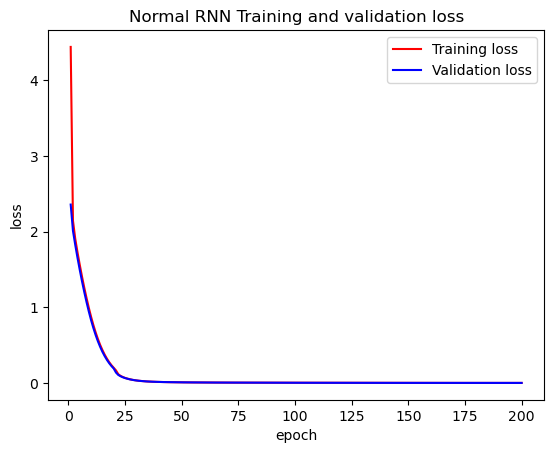

In [197]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\zihaow19\AppData\Local\Temp\ipykernel_21164\151401212.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 14s 61ms/step
(3706, 10, 2)


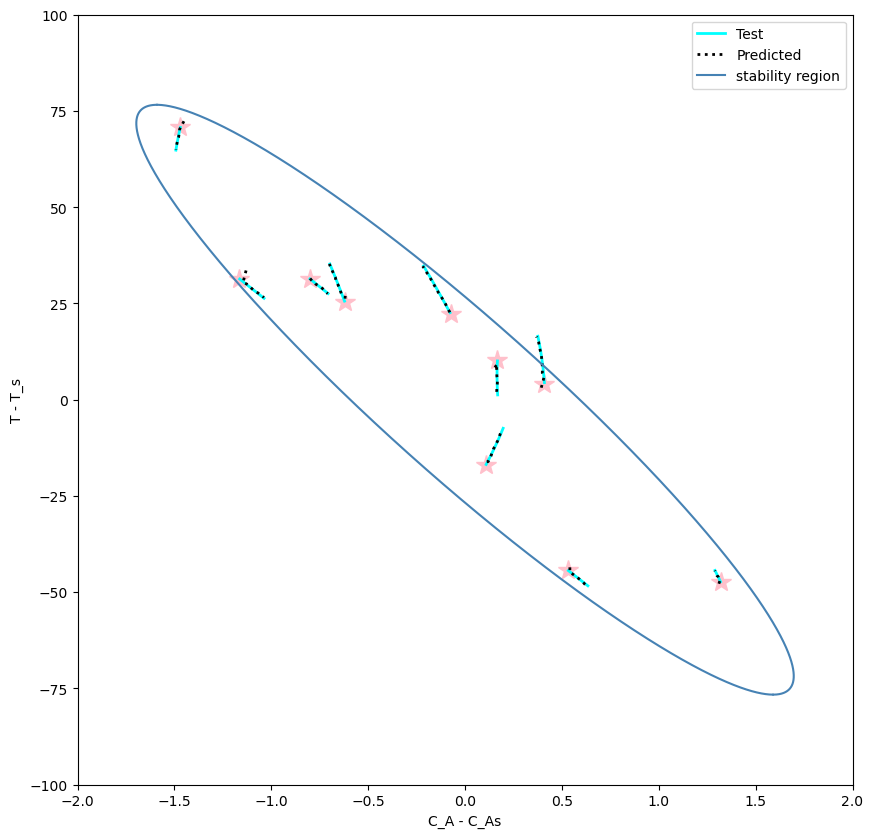

In [198]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
# plt.savefig('iclrnn_noise_0.4.pdf')
plt.show()